In [1]:
%matplotlib widget

import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
import coordinates as coord
import kepler as kpl
from scipy.integrate import odeint # this is new!
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'kepler'

In [33]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

day2sec = 86400.0

## Earth's parameters

In [34]:
a_ell = 6378137.0
c_ell = 6356752.314245
e_ell = np.sqrt(1 - c_ell ** 2  / a_ell ** 2)
mu = 3.986004418e14
# J2 of the Earth (due to Earth's oblateness)
J2 = 1.0826e-3
R_mean = 6371008.0

## Satellite orbit parameters

In [35]:
R        = 6371000.0
altitude = R * 0.1
a0 = R + altitude
e0 = 0.01
i0 = 1  * deg2rad
w0 = 45  * deg2rad
W0 = 225.0 * deg2rad
M0 = 10.0 * deg2rad
t0 = 0.0
t1 = 86400.0 * 1
dt = 60
t  = np.arange(t0, t1, dt)

#### Conversion of anomalies

In [36]:
def E2nu(E, e):
    nu = np.sqrt((1 + e) / (1 - e)) 
    nu = 2 * np.arctan(nu * np.tan(E / 2))
    return nu

def nu2E(nu, e):
    cosnu = np.cos(nu)
    sinnu = np.sin(nu)
    sinE  = np.sqrt(1 - e * e) * sinnu / (1 + e * cosnu)
    cosE = (cosnu + e) / (1 + e * cosnu)
    E = v + np.arctan((sinE * cosnu - cosE * sinnu) / (cosE * cosnu + sinE * sinnu))

def E2M(E, e):
    return E - e * np.sin(E)

def M2E(M, e, E0):
    d   = np.array([1.0])
    eps = 1.0e-12
    E   = E0
    i   = 0
    while (d > eps).any():
        E_new = E - (E - e * np.sin(E) - M) / (1.0 - e * np.cos(E))
        d = np.abs(E_new - E)
        E = E_new
        i = i + 1
    return E, i

def nu2M(nu,e):
    E = nu2E(nu, e) # first, we compute the eccentric anomaly
    return E2M(E, e)

def M2nu(M,e):
    E, _ = M2E(M, e, M) # first, we compute the eccentric anomaly
    return E2nu(E, e)

## Numerical integration example

In [37]:
(x0, y0, z0, vx0, vy0, vz0) = kpl.elem2coord(a0, e0, i0, w0, W0, M0, t0, t0, mu)

#### Define a function that returns the derivative of the state vector

In [38]:
# function that returns dy/dt
def two_body_ode_with_oblateness(y,t):
    r_vec = y[:3]

    # Create the derivative vector and copy the velocities into it
    y_dot = np.zeros_like(y)
    y_dot[:3] = y[3:]

    # Calculate the accelerations
    x = r_vec[0]
    y = r_vec[1]
    z = r_vec[2]
    
    r_mag         = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    a_central_vec = - mu * r_vec / (r_mag ** 3)
    y_dot[3:]     = a_central_vec

    # Compute acceleration due to Earth oblateness
    coef = - mu * J2 * a_ell ** 2 * 0.5

    term = 3 / r_mag ** 4 - 15 * (z ** 2 / r_mag ** 6)
    
    ax_J2 = coef * term * x / r_mag
    ay_J2 = coef * term * y / r_mag
    az_J2 = coef * (6 * z / r_mag ** 5 + term * z / r_mag)

    y_dot[3] = y_dot[3] + ax_J2
    y_dot[4] = y_dot[4] + ay_J2
    y_dot[5] = y_dot[5] + az_J2
    
    return y_dot

#### Create initial conditions 

In [39]:
# initial condition
state_initial = np.array([x0, y0, z0, vx0, vy0, vz0])
print(state_initial)

[ 1.22837053e+06 -6.82879172e+06  9.94462887e+04  7.49778771e+03
  1.33624422e+03  7.60494344e+01]


#### Integrate using ODEINT function from the scipy numerical package

In [40]:
# absolute tolerance
atol = 1e-12

# relative tolerance
rtol = 1e-12

# solve ODE
state = odeint(two_body_ode_with_oblateness, state_initial, t, rtol = rtol, atol = atol)

# extract position and velocity
r_eci_num = state[:,:3]
v_eci_num = state[:,3:]

x = state[:,0]
y = state[:,1]
z = state[:,2]

vx = state[:,3]
vy = state[:,4]
vz = state[:,5]

#### Compute osculating orbital elements

In [41]:
(a, e, i, w, W, M) = kpl.coord2elem(x, y, z, vx, vy, vz, mu)
nu = M2nu(M, e)

#### Compute secular elements

In [12]:
# rates of w and W due to J2
def w_dot(a, e, i, J2, a_ell):
    p    = a * (1 - e ** 2)
    n     = np.sqrt(mu / a / a / a)
    return 1.5 * n * J2 * (a_ell / p) ** 2 * (2 - 2.5 * np.sin(i) ** 2)

def W_dot(a, e, i, J2, a_ell):
    p    = a * (1 - e ** 2)
    n     = np.sqrt(mu / a / a / a)
    return -1.5 * n * J2 * (a_ell / p) ** 2 * np.cos(i)

h_grid = np.arange(500000, 2500000, 500000)
a_grid = R_mean + h_grid
i_grid = np.arange(0, 180, 1) * deg2rad

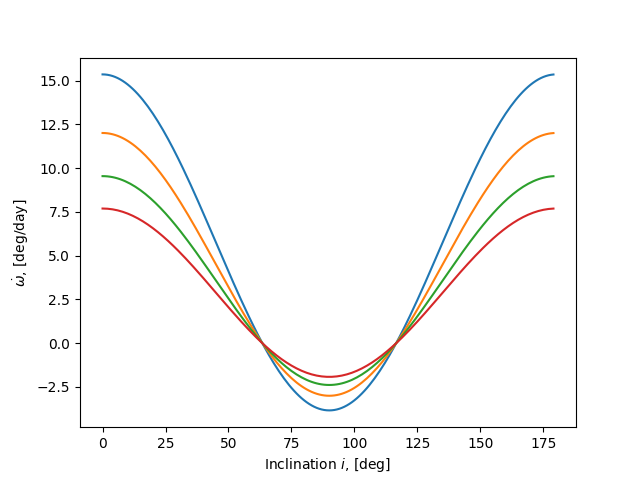

In [13]:
plt.figure()
plt.xlabel("Inclination $i$, [deg]")
plt.ylabel("$\dot{\omega}$, [deg/day]")

for j in range(len(a_grid)):
    w_dot_grid = w_dot(a_grid[j], 0, i_grid, J2, a_ell)
    plt.plot(i_grid * rad2deg, w_dot_grid * rad2deg * 86400.0)

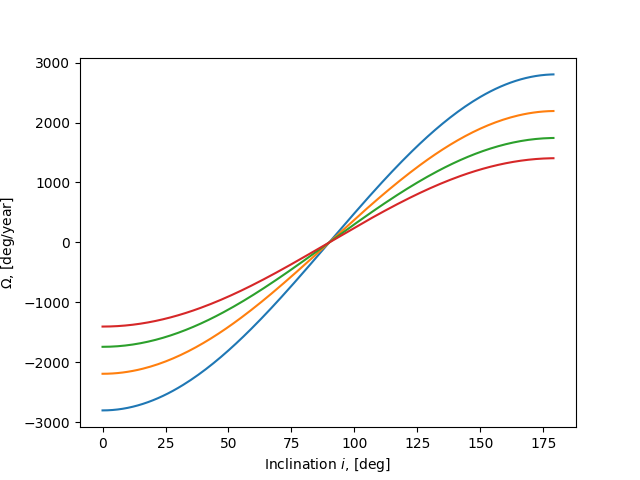

In [14]:
plt.figure()
plt.xlabel("Inclination $i$, [deg]")
plt.ylabel("$\dot{\Omega}$, [deg/year]")

for j in range(len(a_grid)):
    W_dot_grid = W_dot(a_grid[j], 0, i_grid, J2, a_ell)
    plt.plot(i_grid * rad2deg, W_dot_grid * rad2deg * 86400.0 * 365.2422)

In [42]:
w_dot_satellite = w_dot(a0, e0, i0, J2, a_ell)
W_dot_satellite = W_dot(a0, e0, i0, J2, a_ell)

w_secular = w0 + w_dot_satellite * (t - t0)
W_secular = W0 + W_dot_satellite * (t - t0)

## Plot orbital elements

In [16]:
#### Semimajor axis

Text(0, 0.5, 'a [km]')

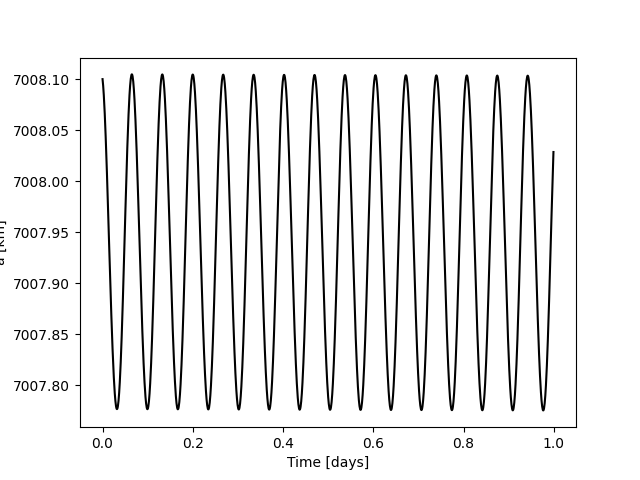

In [43]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, a * 1e-3,'-k')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('a [km]')

In [18]:
#### Eccentricity

Text(0, 0.5, 'Eccentricity []')

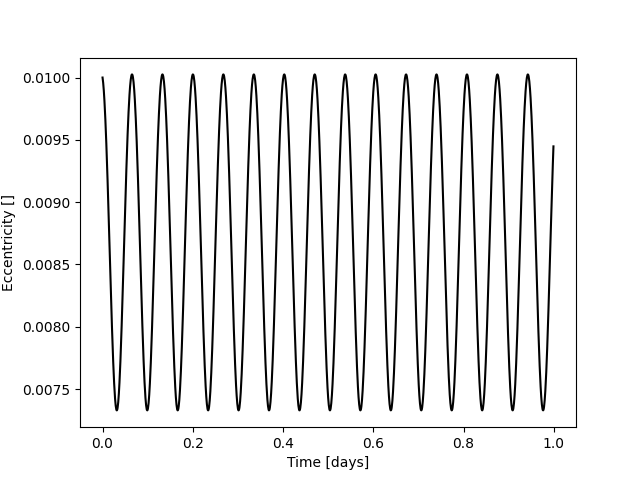

In [44]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, e ,'-k')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('Eccentricity []')

#### Inclination

Text(0, 0.5, 'Inclination [deg]')

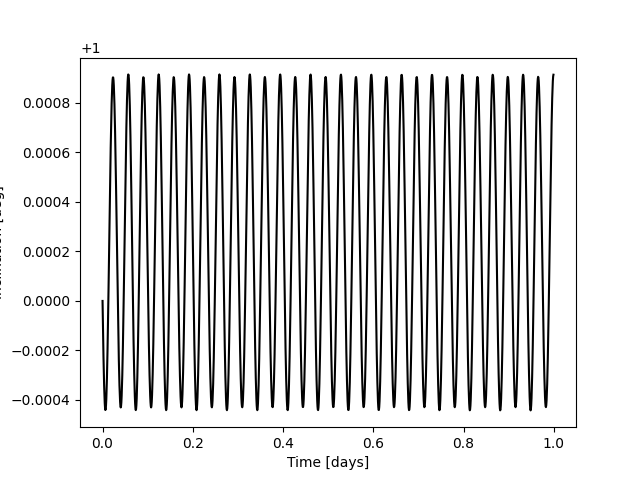

In [45]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, i * rad2deg ,'-k')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('Inclination [deg]')

#### Argument of pericenter

Text(0, 0.5, 'Argument of pericenter [deg]')

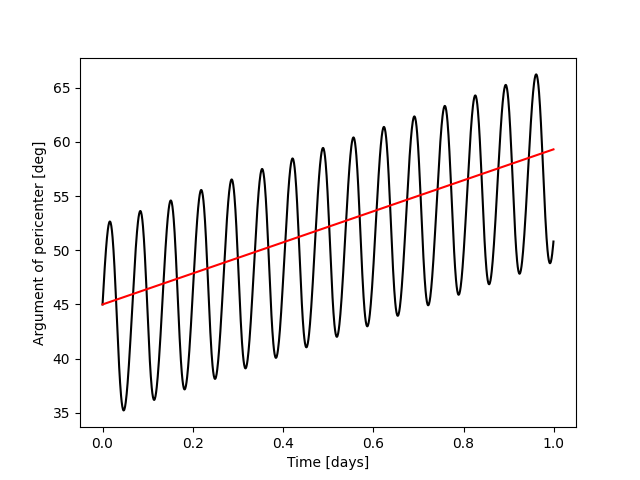

In [46]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, w * rad2deg ,'-k')
plt.plot(t / day2sec, w_secular * rad2deg ,'-r')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('Argument of pericenter [deg]')

#### Longitude of the ascending node

Text(0, 0.5, 'Longitude of the ascending node [deg]')

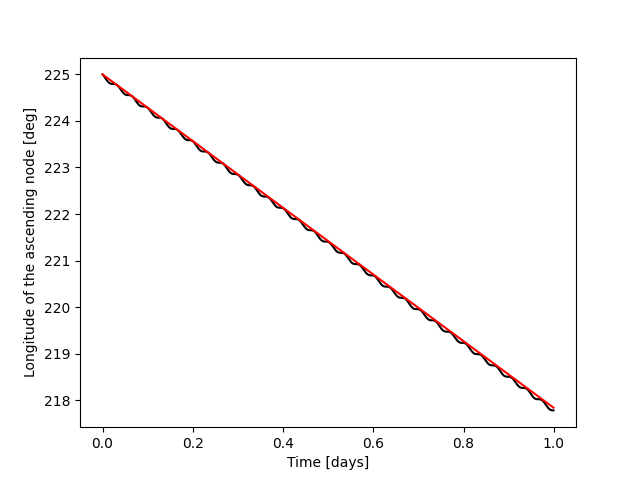

In [47]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, W * rad2deg ,'-k')
plt.plot(t / day2sec, W_secular * rad2deg ,'-r')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('Longitude of the ascending node [deg]')

#### Mean anomaly

Text(0, 0.5, 'Mean anomaly [deg]')

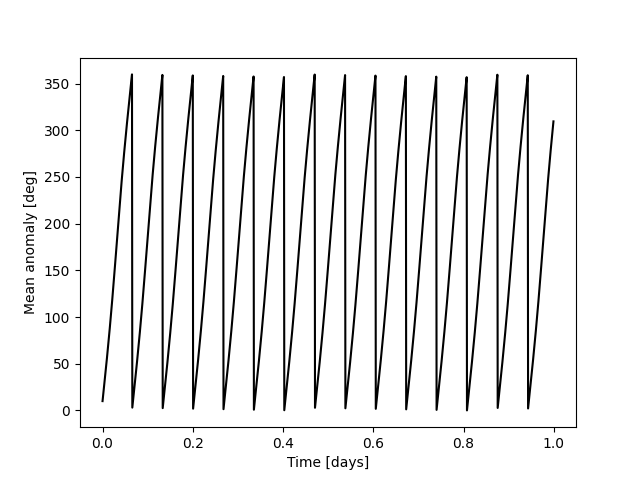

In [49]:
ax = plt.figure()
# Plot orbit
plt.plot(t / day2sec, M * rad2deg ,'-k')

# setting title and labels 
plt.xlabel('Time [days]')
plt.ylabel('Mean anomaly [deg]')

#### Let's see how things change within one orbit

Text(0.5, 0, 'True anomaly [deg]')

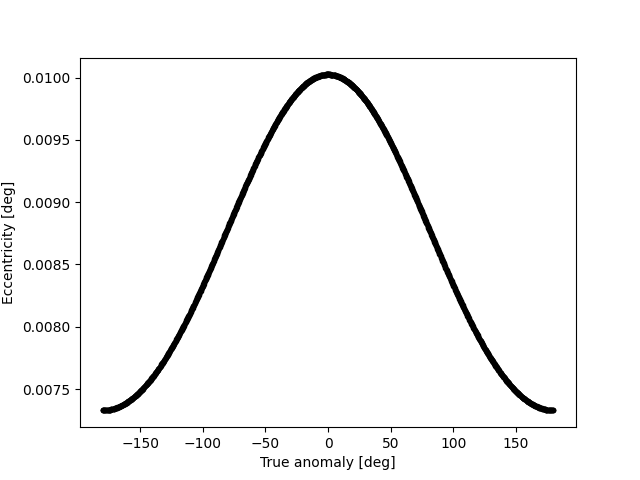

In [58]:
ax = plt.figure()
# Plot orbit
plt.plot( nu * rad2deg , e  , '.k')

# setting title and labels 
plt.ylabel('Eccentricity [deg]')
plt.xlabel('True anomaly [deg]')

#### Variation in inclination

Text(0.5, 0, 'Argument of latitude [deg]')

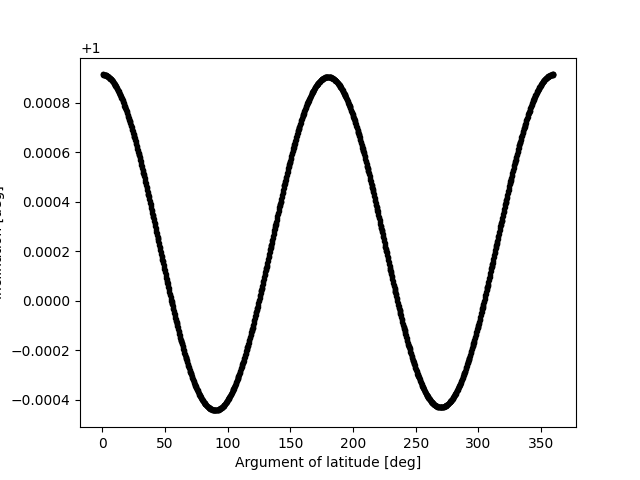

In [59]:
ax = plt.figure()
# Plot orbit
u = (nu + w)

u[u < 0] = u[u < 0] + 2*pi
u[u > 2*pi] = u[u > 2*pi] - 2*pi

plt.plot( u * rad2deg , i * rad2deg , '.k')

# setting title and labels 
plt.ylabel('Inclination [deg]')
plt.xlabel('Argument of latitude [deg]')

In [28]:
#### Variation in mean anomaly

In [55]:
n_unperturbed = np.sqrt(mu / a0 ** 3)
M_unperturbed = np.mod(M0 + n_unperturbed * (t - t0), 2*pi)

# Compute difference in mean anomaly
M_diff = (M - M_unperturbed)
filt1 = M_diff > pi
M_diff[filt1] = M_diff[filt1] - 2 * pi

filt2 = M_diff < - pi
M_diff[filt2] = M_diff[filt2] + 2 * pi

Text(0.5, 0, 'Time [days]')

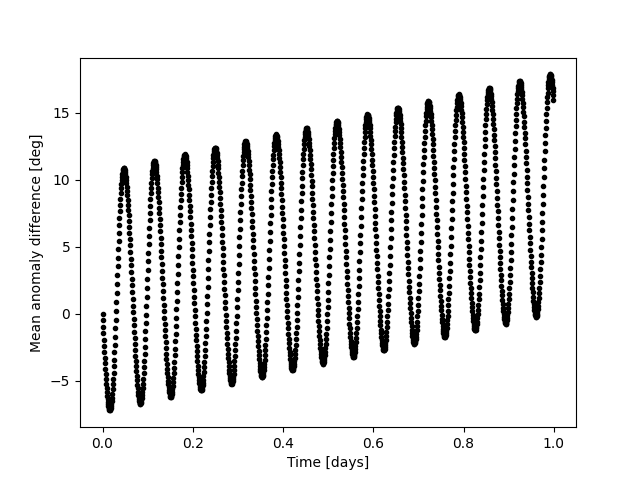

In [56]:
ax = plt.figure()
# Plot orbit
plt.plot( t / day2sec, M_diff * rad2deg , '.k')

# setting title and labels 
plt.ylabel('Mean anomaly difference [deg]')
plt.xlabel('Time [days]')